In [1]:
from calibration import cali

In [2]:
import os, time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import astropy as ap
from astropy.io import fits
from astropy.wcs import WCS
import ccdproc as cc
from scipy import constants as const
import pandas as pd
from photutils import DAOStarFinder
from astropy.stats import mad_std
from photutils import aperture_photometry, CircularAperture

from astroquery.astrometry_net import AstrometryNet
from astroquery.exceptions import TimeoutError
from astropy.stats import mad_std
ast = AstrometryNet()
ast.API_URL = 'http://nova.astro.gla.ac.uk/api' # local server
ast.api_key = 'XXXXXXXX'
ast.URL = 'http://nova.astro.gla.ac.uk'

import warnings
warnings.filterwarnings('ignore')


/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_28951/1249201792.py:11: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder
/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_28951/1249201792.py:13: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry, CircularAperture
/var/folders/tn/fqh6631n3p56r504tcsqvss00000gn/T/ipykernel_28951/1249201792.py:13: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please

In [3]:
# im = '/images/TZ-Aur_LIGHT_2023-01-22T18-39-42Z_Chr-G_30s_-15.0C_W_0001.fits'
img = cali('TZ-Aur_LIGHT_2023-01-22T18-39-42Z_Chr-G_30s_-15.0C_W_0001.fits', 'flat_g_master.fits' , 'dark_30s_master.fits','dark_flat_gr_3s_master.fits')



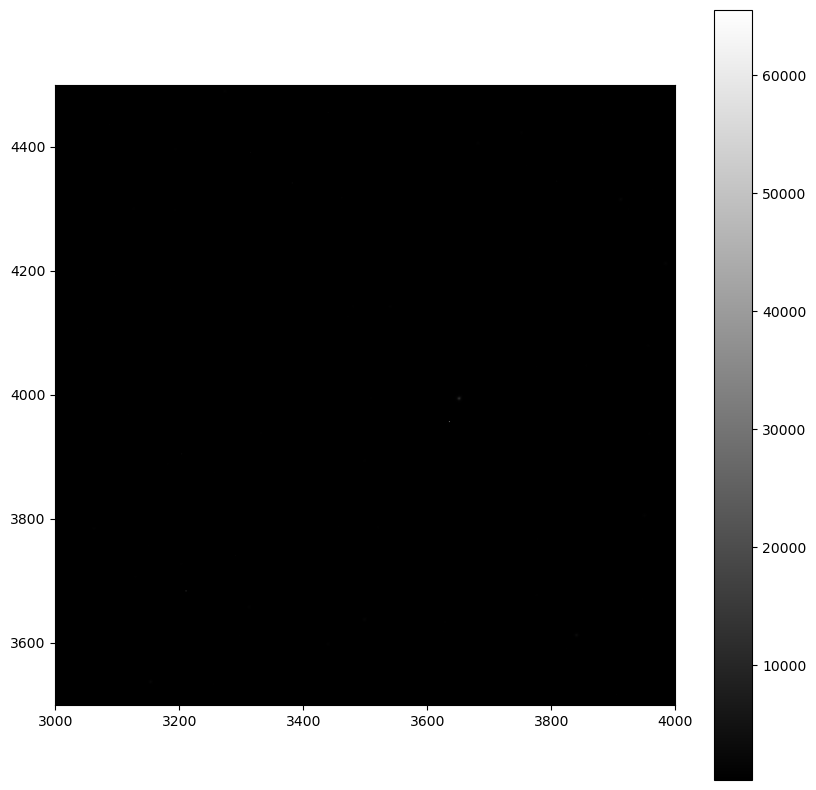

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(fits.open('TZ-Aur_LIGHT_2023-01-22T18-39-42Z_Chr-G_30s_-15.0C_W_0001.fits')[0].data)
plt.set_cmap('gray')
plt.xlim(3000,4000)
plt.ylim(3500,4500)
plt.colorbar()

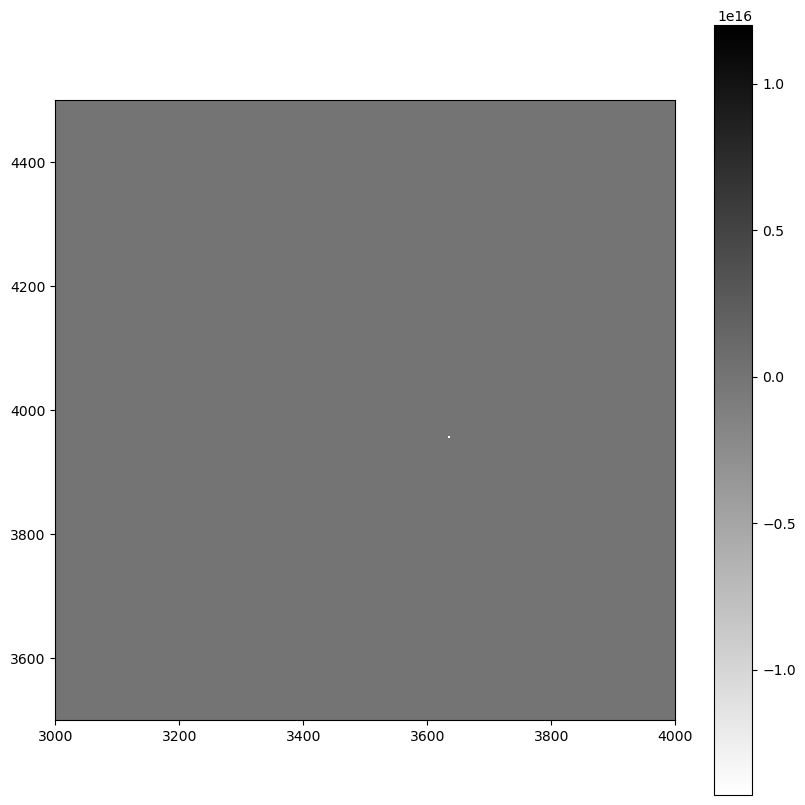

In [12]:
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.set_cmap('gray_r')
plt.xlim(3000,4000)
plt.ylim(3500,4500)
plt.colorbar()

In [16]:
files = os.listdir('/cali_img')
for file in files:

    with fits.open(file) as hdu:
        header = hdu[0].header
        data = hdu[0].data


    # print_header(header)   

    fig1 = plt.figure(figsize=(16,16))
    # get some colour scaling for the image
    d_mean = np.mean(data);     # mean intensity
    d_std  = np.std(data);      # standard deviation of intensity
    vmin = d_mean - d_std/2     # brightness at colour scale minimum
    vmax = d_mean + d_std       # brightness at colour scale maximum

    # get it approximately the right way round
    data = np.rot90(data,1)


    im1 = plt.imshow(data, vmin = vmin, vmax=vmax, cmap='gray_r')
    plt.colorbar(im1, orientation='horizontal')

    plt.xlabel('x (pixels)')
    plt.ylabel('y (pixels)')

FileNotFoundError: [Errno 2] No such file or directory: '/cali_img'

In [ ]:


bkg_sigma = mad_std(data)                                    # get a measure of the image noise level
daofind = DAOStarFinder(fwhm=6, threshold=20*bkg_sigma)     # set the detection threshold for a source based on the image noise
#             IRAFstarfinder()
                                                             # a lower theshold will give more sources, but will start picking up noise
sources = daofind(data)  
for col in sources.colnames:  
    sources[col].info.format = '%.6g'  # for consistent table output 


sources.sort('flux') # sources are sorted by y position, more useful to sort them by flux
sources.reverse()    # reverse order so list is in decending order of flux
sources              # this prints a neat table of all the sources found. print(sources) also works



In [ ]:
fig2 = plt.figure(figsize=(16,10))
plt.imshow(data, vmin = vmin, vmax=vmax, cmap='gray_r')

# for each source plot a circular aperture, radius 8 pixels (these are normally used for photometry, but useful for plotting sources too)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=30)  
p = apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [ ]:
image_width, image_height = data.shape
wcs_header = None             # this variable will hld the result from the solver when it has completed
t_start = time.time()
try:
    print('Sending data to AstrometryNet server:')
    wcs_header = ast.solve_from_source_list(sources['xcentroid'], sources['ycentroid'],
                                            image_width, image_height,
                                            solve_timeout=300)
    if wcs_header:   # This will be true (ie not 'None') if the image solves sucessfully, and will contain a fits header with the solved image parameters (WCS)
        print('\n -> Success. Solving took {:0.1f}s'.format(time.time()-t_start))
        print_header(wcs_header)         # the print_header function is in a345_utilities - see import statement at start. You can just use print(header), but it is a bit unwieldy
    else:
        print('\n -> Solving failed after {:0.1f}s'.format(time.time()-t_start))   
except TimeoutError:
    #If you run out of time         
    print('\n -> ##FAIL: Timeout while solving, try a longer timeout, optmise number of sources (200-800 seems about right)')


In [ ]:
# update the existing header with the WCS data:
print('Updated header, with WCS added:')
header.update(wcs_header)   # add in the solved WCS info
print_header(header)        # print the header with is added WCS data

# now save the calibrated file ready for analysis. This would normally be the end of a script like this:
# do any science analysis by loading the calibrated fits files from a different script

# The easiest way to save the fils file is to create a new  fits abject, and add the data and calibrated header 
hdu = fits.PrimaryHDU()         # create a FITS HDU object
hdu.data = data
hdu.header = header
hdu.header.update(wcs_header)       # add in the header containg the wcs data

output_file = 'images/M44_calibrated_wcs.fits'
print('Saving calibrated file: {}'.format(output_file))
hdu.writeto(output_file, overwrite=True)

In [ ]:
# just to check: load the calibrated file and plot, using the wcs data
with fits.open(output_file) as hdu:
    reloaded_header = hdu[0].header
    reloaded_data   = hdu[0].data

wcs = WCS(reloaded_header)
wcs.printwcs()
print(wcs.get_axis_types())

fig = plt.figure(figsize=(10,18))
ax = plt.subplot(projection=wcs)
#get some colour limits
mean_intensity = np.mean(data)
r = 200
plt.imshow(data,vmin=mean_intensity, vmax = mean_intensity+r, cmap='gray')    
plt.grid(color='lightblue', ls='solid')    

# flip the y-axis to get dec increasing to the top
plt.gca().invert_yaxis()
plt.show()